# Addestramento modello

In questo caso, viene considerato il classificatore RandomForest.

> Import necessari

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

> Montaggio di Drive

In [109]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Divisione del dataset in train e test

In [ ]:
# Lettura del dataset (drive)
csv_path = '/content/drive/MyDrive/Progetto_FDSML_github/FakeAccountDetection/datasets/cleaned_dataset.csv'

In [14]:
# Lettura del dataset (local)
csv_path = '../datasets/cleaned_dataset.csv'

In [15]:
df = pd.read_csv(csv_path)

In [ ]:
# Divisione in train e test set
X = df.copy()
y = X.pop('fake')

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

### 1.1 Addestramento senza iperparametri

In [137]:
# Istanziazione e addestramento del classificatore
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9990044798407167
Precision: 0.998015873015873
Recall: 1.0
F1-Score: 0.9990069513406157


## 2. Grid Search Cross Validation

In [138]:
# Griglia dei parametri
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20]
}

In [139]:
# Istanziazione del classificatore (random_state garantisce che ad ogni esecuzione vi siano sempre gli stessi iperparametri migliori)
rfc = RandomForestClassifier(random_state=42)

In [140]:
%%time
# Stampiamo i migliori parametri
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True, error_score='raise')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
CPU times: total: 453 ms
Wall time: 18.6 s


In [141]:
# Vediamo come si comporta nelle diverse combinazioni di parametri
cvres = grid_search.cv_results_

for i, (accuracy, params) in enumerate(zip(cvres["mean_test_score"], cvres["params"])):
    print(f"Iterazione {i}: Accuracy {accuracy}, Parametri {params}")

Iterazione 0: Accuracy 0.9977591804365469, Parametri {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Iterazione 1: Accuracy 0.9976346474353017, Parametri {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Iterazione 2: Accuracy 0.9972610484315656, Parametri {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
Iterazione 3: Accuracy 0.997634492543509, Parametri {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Iterazione 4: Accuracy 0.997385581432811, Parametri {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Iterazione 5: Accuracy 0.9973855814328111, Parametri {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Iterazione 6: Accuracy 0.9976348023270942, Parametri {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
Iterazione 7: Accuracy 0.9976346474353017, Parametri {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}


## 3. Feature Importances (only Random Forest)

In [142]:
# Vediamo l'importanza delle features in fase di addestramento
df_feature_importances = pd.DataFrame({
    'featureImportance': grid_search.best_estimator_.feature_importances_,
    'attribute': X_train.columns
})

df_feature_importances_sorted = df_feature_importances.sort_values(by='featureImportance', ascending=False)
df_feature_importances_sorted.reset_index(inplace=True, drop=True)
df_feature_importances_sorted

,featureImportance,attribute
0,0.366345,followerCount
1,0.158572,followingCount
2,0.133443,videoCount
3,0.094080,heartCount
4,0.071456,nicknameLength
5,0.048994,diggCount
6,0.029839,signatureLength
7,0.029479,nicknameNumSpecialCharacters
8,0.028296,openFavorite
9,0.020240,uniqueIdLength


## 4. Metriche del modello migliore

> Vengono misurate le metriche a seguito dell'Hyperparameter Tuning.

In [143]:
rfc_final = grid_search.best_estimator_
y_pred = rfc_final.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9980089596814335
Precision: 0.9980119284294234
Recall: 0.9980119284294234
F1-Score: 0.9980119284294234


### 4.1 Learning Curve

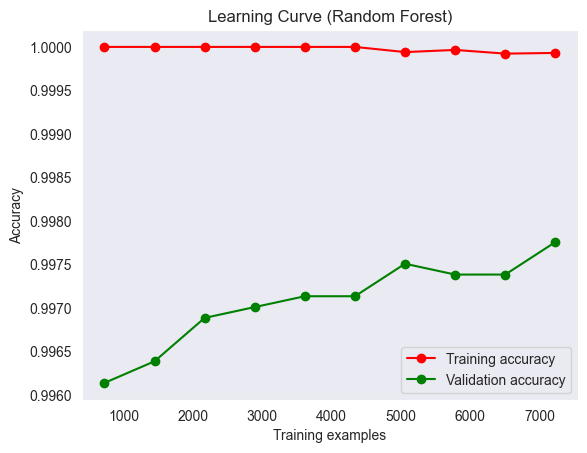

In [144]:
# Istanzia un nuovo modello Random Forest con i migliori parametri ottenuti in precedenza
rfc = RandomForestClassifier(random_state=42, **grid_search.best_params_)

# Calcolo la learning curve
train_sizes, train_scores, test_scores = learning_curve(rfc, X_train, y_train, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, cv=10)

# Calcola la media dei punteggi ottenuti nelle diverse iterazioni di cross validation
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Traccio la curva di apprendimento
plt.figure()
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation accuracy")

plt.legend(loc="best")
plt.show()

### 4.2 Matrice di confusione

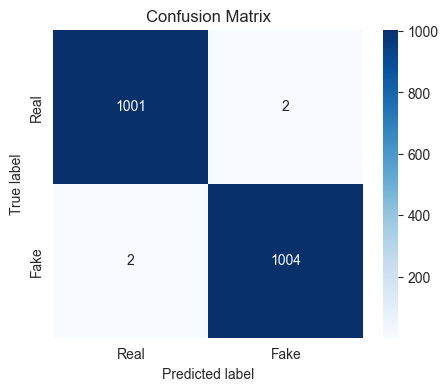

<Figure size 640x480 with 0 Axes>

In [125]:
cm = confusion_matrix(y_test, y_pred)
class_names = ['Real', 'Fake']

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Salva il grafico come file PDF
plt.savefig('confusion_matrix_NameOfClassifier.pdf', format='pdf')

### 4.3 Roc Curve

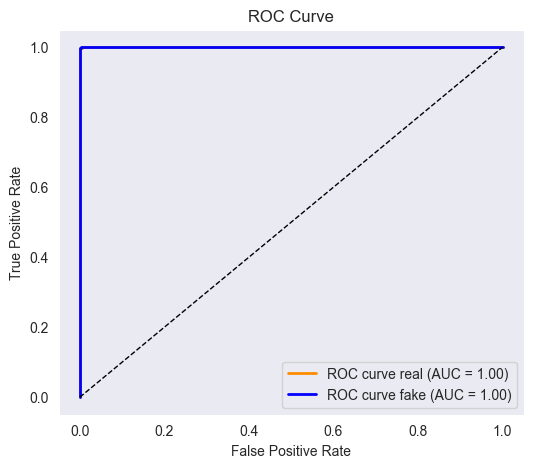

In [133]:
y_proba = rfc_final.predict_proba(X_test)

# Calcolo della curva ROC per la classe 'real' (label 0)
fpr_real, tpr_real, _ = roc_curve(y_test, y_proba[:, 0], pos_label=0)
roc_auc_real = auc(fpr_real, tpr_real)

# Calcolo della curva ROC per la classe 'fake' (label 1)
fpr_fake, tpr_fake, _ = roc_curve(y_test, y_proba[:, 1], pos_label=1)
roc_auc_fake = auc(fpr_fake, tpr_fake)

# Tracciamento delle curve ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_real, tpr_real, color='darkorange', lw=2, label=f'ROC curve real (AUC = {roc_auc_real:.2f})')
plt.plot(fpr_fake, tpr_fake, color='blue', lw=2, label=f'ROC curve fake (AUC = {roc_auc_fake:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.show()